In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# !pip install livelossplot
from livelossplot import PlotLossesKeras

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16.csv")
df.head(3)

,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87


In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.head(3)

,ToVol,SmVol,MeVol,LaVol,Speed,OccRate
Date,,,,,,
2017-04-02 0:00,43,34,9,0,50.3,1.90
2017-04-02 0:05,45,32,13,0,58.9,1.84
2017-04-02 0:10,46,34,12,0,50.6,1.87


In [8]:
df_spd = df.iloc[:,4:5].values  #Speed
print(df_spd)
print(df_spd.shape)

[[50.3]
 [58.9]
 [50.6]
 ...
 [50.6]
 [59.3]
 [52.5]]
(8064, 1)


In [9]:
y=df['Speed'].values

In [10]:
print(y)

[50.3 58.9 50.6 ... 50.6 59.3 52.5]


In [11]:
max_speed = df_spd.max(); max_speed

87.8

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_spd)

scaled_df

array([[0.12277801],
       [1.20844949],
       [0.16065027],
       ...,
       [0.16065027],
       [1.25894584],
       [0.40050793]])

In [20]:
look_back = 144

In [21]:
X = []
y = []
for i in range(len(scaled_df)-look_back-1):
    X.append(scaled_df[i:(i+look_back)])
    y.append(scaled_df[(i+look_back)])

X = np.array(X)
y = np.array(y)

In [22]:
print(X.shape, y.shape)

(7919, 144, 1) (7919, 1)


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(5543, 144, 1) (5543, 1)
(2376, 144, 1) (2376, 1)


In [24]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential

In [25]:
def simple_rnn():
    model = Sequential([
        SimpleRNN(10, input_shape=(X_train.shape[1],1)),
        Dense(20),          
        Dense(1)
    ])    
    
    model.compile(optimizer='adam', loss= 'mse', metrics=['mae'])
    return model

In [26]:
model = simple_rnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 20)                220       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


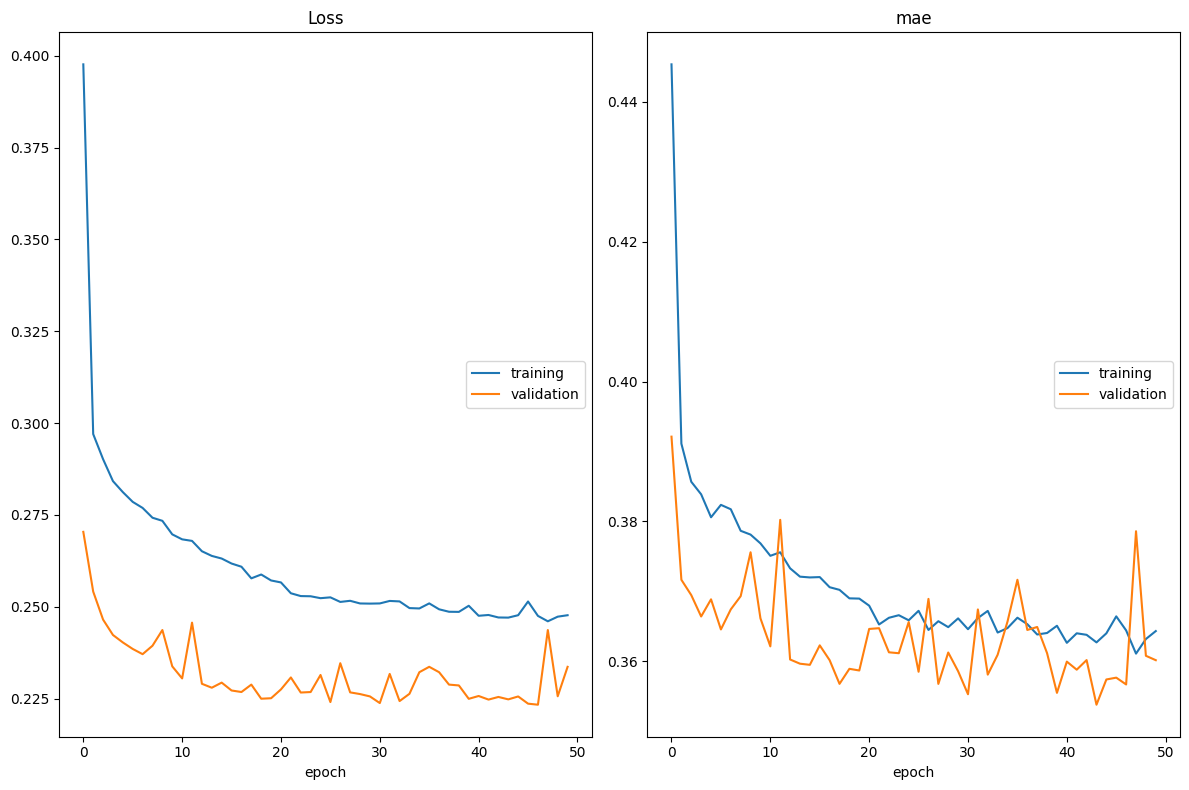

Loss
	training         	 (min:    0.246, max:    0.398, cur:    0.248)
	validation       	 (min:    0.223, max:    0.270, cur:    0.234)
mae
	training         	 (min:    0.361, max:    0.445, cur:    0.364)
	validation       	 (min:    0.354, max:    0.392, cur:    0.360)
139/139 [==============================] - 5s 33ms/step - loss: 0.2477 - mae: 0.3643 - val_loss: 0.2337 - val_mae: 0.3602


In [27]:
history = model.fit(X_train,y_train, epochs=50, 
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[PlotLossesKeras()])

In [28]:
# 테스트 데이터 세트로 모델 평가: Loss 값 확인 
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print("\nlook_back={:3d},  MSE={:8.4f}, MAE={:8.4f}".format(look_back,mse,mae))


look_back=144,  MSE=  0.2668, MAE=  0.3705


In [29]:
y_pred = model.predict(X_test, verbose=0)
print(y_pred.shape,y_test.shape)

(2376, 1) (2376, 1)


In [30]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [31]:
pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_df.head()

,Actual,Predicted
0,46.2,46.516399
1,46.4,47.162922
2,44.7,47.717911
3,49.5,49.719784
4,43.9,44.769798


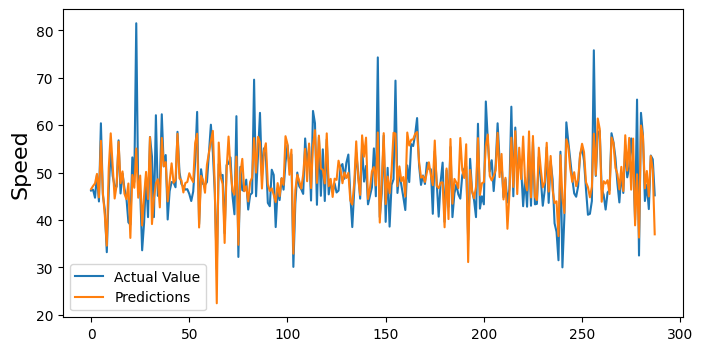

In [32]:
plt.figure(figsize=(8,4))
plt.ylabel('Speed', fontsize=16)
plt.plot(pred_df[:288])
plt.legend(['Actual Value', 'Predictions'])
plt.show()

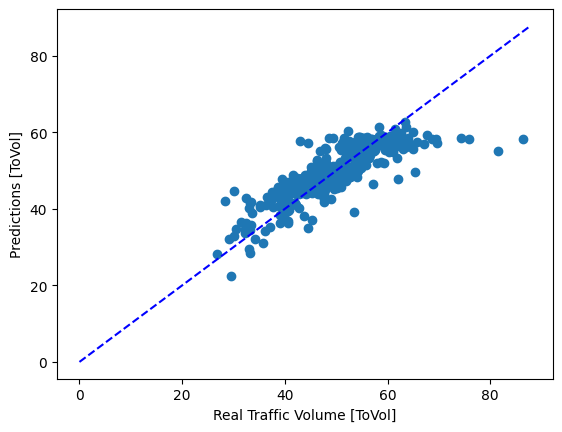

In [33]:
plt.scatter(y_test.flatten()[:576], y_pred.flatten()[:576])
plt.xlabel('Real Traffic Volume [ToVol]')
plt.ylabel('Predictions [ToVol]')
plt.plot([0, max_speed], [0, max_speed],'b--')

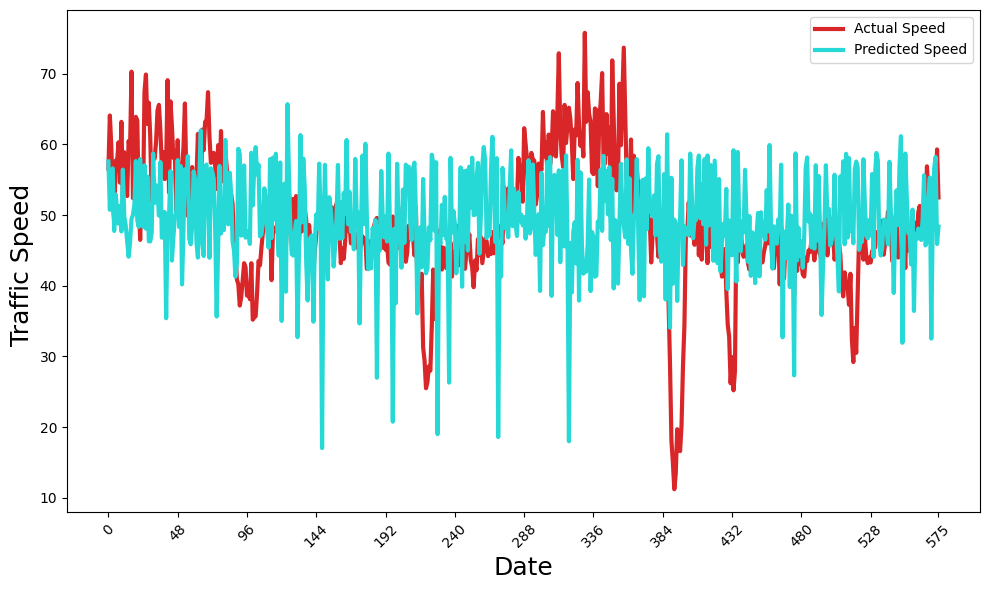

In [36]:
plt.figure(figsize=(10,6))
#plt.style.use("dark_background")

plt.plot(df_spd[-576:], linewidth= 3,  color='#d92628', label='Actual Speed')
#plt.plot(df["Date"].iloc[-576:], df_uni[-576:], linewidth= 3,  color='#d92628', label='Actual Speed')
plt.plot(y_pred[-576:], color='#26D9D7', linewidth= 3, label='Predicted Speed')
plt.xlabel("Date", size="18")
plt.ylabel("Traffic Speed ", size="18")
plt.xticks([0, 48, 96, 144,192, 240, 288, 336, 384, 432, 480, 528,575],rotation=45)

plt.tight_layout()
plt.legend()

In [ ]:
plt.scatter(pred_df)